In [4]:
import numpy as np
import cvxpy as cp
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# -----------------------------
# Optimistic combinatorial bandit with global budget
# -----------------------------
class OptimisticBandit:
    def __init__(self, products, prices, budget, T):
        self.products = products
        self.prices = prices
        self.budget = budget
        self.T = T
        self.n = defaultdict(int)
        self.sum_r = defaultdict(float)
        self.sum_c = defaultdict(float)

    def conf_width(self, n):
        return np.sqrt((2 * np.log(self.T)) / n) if n>0 else 1.0

    def play(self, t, rho_t):
        atoms = [(p, pr) for p in self.products for pr in self.prices[p]]
        r_ucb, c_lcb = {}, {}

        for a in atoms:
            n = self.n[a]
            mean_r = self.sum_r[a]/n if n>0 else 0.0
            mean_c = self.sum_c[a]/n if n>0 else 0.0
            w = self.conf_width(n)
            r_ucb[a] = mean_r + w
            c_lcb[a] = max(0.0, mean_c - w)

        x = {a: cp.Variable(boolean=False) for a in atoms}
        obj = cp.Maximize(cp.sum([x[a]*r_ucb[a] for a in atoms]))
        constraints = [cp.sum([x[a]*c_lcb[a] for a in atoms]) <= rho_t]

        for p in self.products:
            constraints.append(cp.sum([x[(p,pr)] for pr in self.prices[p]]) <= 1)
        for a in atoms:
            constraints.append(x[a] >= 0)
            constraints.append(x[a] <= 1)

        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.GLPK_MI)

        action = {}
        for p in self.products:
            best_price, best_val = None, -1
            for pr in self.prices[p]:
                val = x[(p,pr)].value
                if val is not None and val > best_val:
                    best_val = val
                    best_price = pr
            if best_price is not None:
                action[p] = best_price
        return action

    def update(self, outcomes, t):
        for (p,pr), (r,c) in outcomes.items():
            self.n[(p,pr)] += 1
            self.sum_r[(p,pr)] += r
            self.sum_c[(p,pr)] += c

In [2]:
import numpy as np
from scipy import stats

class MultiProductPricingEnvironment:
    def __init__(self, products, prices,
                 copula_type='gaussian',
                 copula_param=0.5,
                 marginal_type='beta',
                 a=2, b=5,
                 joint_type=None,
                 dirichlet_alpha=None):
        self.products = products
        self.d = len(products)
        self.prices = prices
        self.copula_type = copula_type
        self.copula_param = copula_param
        self.marginal_type = marginal_type
        self.a = a
        self.b = b
        self.joint_type = joint_type  # if not None, overrides copula
        self.dirichlet_alpha = dirichlet_alpha if dirichlet_alpha is not None else [1]*self.d

        # Gaussian / t copula setup
        if copula_type in ['gaussian', 't']:
            self.mean = np.zeros(self.d)
            self.cov = np.full((self.d, self.d), copula_param)
            np.fill_diagonal(self.cov, 1.0)
            if copula_type == 't':
                self.df = 3

        # Define marginals (in [0,1])
        if marginal_type == 'beta':
            self.marginals = [stats.beta(a, b) for _ in range(self.d)]
        elif marginal_type == 'uniform':
            self.marginals = [stats.uniform(0, 1) for _ in range(self.d)]
        else:
            raise ValueError('Unsupported marginal distribution')

    def _sample_copula(self):
        """Generate U(0,1)^d samples from chosen copula."""
        if self.copula_type == 'gaussian':
            z = np.random.multivariate_normal(self.mean, self.cov)
            u = stats.norm.cdf(z)
        elif self.copula_type == 't':
            z = stats.t.rvs(df=self.df, size=self.d)
            L = np.linalg.cholesky(self.cov)
            z = L @ z
            u = stats.t.cdf(z, df=self.df)
        elif self.copula_type == 'independent':
            u = np.random.rand(self.d)
        elif self.copula_type == 'clayton':
            theta = self.copula_param
            w = np.random.gamma(1/theta, 1, size=1)
            e = np.random.exponential(1, size=self.d)
            u = (1 + e / w)**(-1/theta)
        elif self.copula_type == 'gumbel':
            theta = self.copula_param
            e = -np.log(np.random.rand(self.d))
            s = np.sum(e**theta)**(1/theta)
            u = np.exp(-e/s)
        else:
            raise ValueError('Unsupported copula type')
        return np.clip(u, 1e-6, 1-1e-6)

    def _sample_joint(self):
        """Direct joint distributions (no copula)."""
        if self.joint_type == 'dirichlet':
            u = np.random.dirichlet(self.dirichlet_alpha)
            return u
        elif self.joint_type == 'multivariate_uniform':
            return np.random.rand(self.d)
        elif self.joint_type == 'correlated_beta':
            # correlated via latent normal + logistic transform
            z = np.random.multivariate_normal(np.zeros(self.d), self.cov)
            u = 1 / (1 + np.exp(-z))  # sigmoid in (0,1)
            return u
        else:
            raise ValueError('Unsupported joint distribution')

    def sample_valuations(self):
        if self.joint_type is not None:
            u = self._sample_joint()
            return np.array([self.marginals[i].ppf(u[i]) for i in range(self.d)])
        else:
            u = self._sample_copula()
            return np.array([self.marginals[i].ppf(u[i]) for i in range(self.d)])

    def round(self, chosen_prices):
        chosen_prices_arr = np.array([chosen_prices[p] for p in self.products], dtype=float)
        vals = self.sample_valuations()
        sold = (vals >= chosen_prices_arr).astype(int)
        reward = float(np.dot(chosen_prices_arr, sold))
        return sold, reward


In [5]:
# -----------------------------
# Oracle (clairvoyant)
# -----------------------------
def oracle_action(products, prices, env, rho_t):
    atoms = [(p,pr) for p in products for pr in prices[p]]
    true_r = {a:0.0 for a in atoms}
    true_c = {a:0.0 for a in atoms}
    vals = env.sample_valuations()
    for i,p in enumerate(products):
        for pr in prices[p]:
            sold = int(vals[i] >= pr)
            true_r[(p,pr)] = sold*pr
            true_c[(p,pr)] = sold

    x = {a: cp.Variable(boolean=False) for a in atoms}
    obj = cp.Maximize(cp.sum([x[a]*true_r[a] for a in atoms]))
    constraints = [cp.sum([x[a]*true_c[a] for a in atoms]) <= rho_t]
    for p in products:
        constraints.append(cp.sum([x[(p,pr)] for pr in prices[p]]) <= 1)
    for a in atoms:
        constraints.append(x[a]>=0)
        constraints.append(x[a]<=1)

    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.GLPK_MI)

    action = {}
    expected_reward = 0
    for p in products:
        best_price, best_val = None, -1
        for pr in prices[p]:
            val = x[(p,pr)].value
            if val is not None and val > best_val:
                best_val = val
                best_price = pr
        if best_price is not None:
            action[p] = best_price
            expected_reward += true_r[(p,best_price)]
    return action, expected_reward

### old

In [ ]:
class MultiProductPricingEnvironment:
    def __init__(self, products, prices, distribution_type='gaussian_copula', copula_param=0.5, a=2, b=5):
        self.products = products
        self.d = len(products)
        self.prices = prices
        self.distribution_type = distribution_type
        self.copula_param = copula_param
        self.a = a
        self.b = b

        # Copula parameters
        if distribution_type in ['gaussian_copula', 't_copula']:
            self.mean = np.zeros(self.d)
            self.cov = np.full((self.d, self.d), copula_param)
            np.fill_diagonal(self.cov, 1.0)
            if distribution_type == 't_copula':
                self.df = 3

        # Marginals (Beta)
        self.marginals = [stats.beta(a, b) for _ in range(self.d)]

    def sample_valuations(self):
        if self.distribution_type == 'gaussian_copula':
            z = np.random.multivariate_normal(self.mean, self.cov)
            u = stats.norm.cdf(z)
        elif self.distribution_type == 't_copula':
            z = stats.t.rvs(df=self.df, size=self.d)
            L = np.linalg.cholesky(self.cov)
            z = L @ z
            u = stats.t.cdf(z, df=self.df)
        elif self.distribution_type == 'independent':
            u = np.random.beta(self.a, self.b, size=self.d)
        else:
            raise ValueError('Unsupported distribution type')
        return np.array([self.marginals[i].ppf(u[i]) for i in range(self.d)])

    def round(self, chosen_prices):
        """
        chosen_prices: dict of product -> price
        Returns:
            sold: integer array of length d (1 if sold, 0 if not)
            reward: sum of prices for sold products
        """
        chosen_prices_arr = np.array([chosen_prices[p] for p in self.products], dtype=float)
        vals = self.sample_valuations()
        sold = (vals >= chosen_prices_arr).astype(int)  # always integer
        reward = float(np.dot(chosen_prices_arr, sold))
        return sold, reward


In [ ]:
class MultiProductPricingEnvironment:
    def __init__(self, products, prices, distribution_type='gaussian_copula', copula_param=0.5, a=2, b=5):
        self.products = products
        self.d = len(products)
        self.prices = prices  # dict of product -> list of prices in [0,1]
        self.distribution_type = distribution_type
        self.copula_param = copula_param
        self.a = a
        self.b = b

        # Gaussian copula parameters
        if distribution_type in ['gaussian_copula', 't_copula']:
            self.mean = np.zeros(self.d)
            self.cov = np.full((self.d, self.d), copula_param)
            np.fill_diagonal(self.cov, 1.0)
            if distribution_type == 't_copula':
                self.df = 3

        # Marginals (Beta distributions)
        self.marginals = [stats.beta(a, b) for _ in range(self.d)]

    def sample_valuations(self):
        if self.distribution_type == 'gaussian_copula':
            z = np.random.multivariate_normal(self.mean, self.cov)
            u = stats.norm.cdf(z)
        elif self.distribution_type == 't_copula':
            z = stats.t.rvs(df=self.df, size=self.d)
            L = np.linalg.cholesky(self.cov)
            z = L @ z
            u = stats.t.cdf(z, df=self.df)
        elif self.distribution_type == 'independent':
            u = np.random.beta(self.a, self.b, size=self.d)
        else:
            raise ValueError('Unsupported distribution type')
        return np.array([self.marginals[i].ppf(u[i]) for i in range(self.d)])

    def round(self, chosen_prices):
        """
        Simulate a single customer round.
        Parameters:
            chosen_prices: array-like of prices for each product
        Returns:
            sold: binary array indicating which products were sold
            reward: total revenue for this round
        """
        chosen_prices = np.array(chosen_prices, dtype=float)
        vals = self.sample_valuations()  # single customer valuations
        sold = (vals >= chosen_prices).astype(int)  # 1 if sold, 0 otherwise
        reward = float(np.dot(chosen_prices, sold))
        return sold, reward


In [ ]:
# -----------------------------
# Multi-product pricing environment (joint distribution, valuations only)
# -----------------------------
class MultiProductPricingEnvironment_internalBudget:
    def __init__(self, products, prices, distribution_type='gaussian_copula', copula_param=0.5, a=2, b=5):
        self.products = products
        self.d = len(products)
        self.prices = prices  # dict of product -> list of prices in [0,1]
        self.distribution_type = distribution_type
        self.copula_param = copula_param
        self.a = a
        self.b = b

        # Gaussian copula parameters
        if distribution_type in ['gaussian_copula', 't_copula']:
            self.mean = np.zeros(self.d)
            self.cov = np.full((self.d, self.d), copula_param)
            np.fill_diagonal(self.cov, 1.0)
            if distribution_type == 't_copula':
                self.df = 3

        # Marginals (Beta distributions)
        self.marginals = [stats.beta(a, b) for _ in range(self.d)]

    def sample_valuations(self):
        if self.distribution_type == 'gaussian_copula':
            z = np.random.multivariate_normal(self.mean, self.cov)
            u = stats.norm.cdf(z)
        elif self.distribution_type == 't_copula':
            z = stats.t.rvs(df=self.df, size=self.d)
            L = np.linalg.cholesky(self.cov)
            z = L @ z
            u = stats.t.cdf(z, df=self.df)
        elif self.distribution_type == 'independent':
            u = np.random.beta(self.a, self.b, size=self.d)
        else:
            raise ValueError('Unsupported distribution type')
        return np.array([self.marginals[i].ppf(u[i]) for i in range(self.d)])

    def round(self, chosen_prices):
      chosen_prices = np.array(chosen_prices, dtype=float)
      vals = self.sample_valuations()  # single customer per round
      sold = (vals >= chosen_prices).astype(int)
      reward = float(np.dot(chosen_prices, sold))
      total_consumption = sold.sum()
      # Apply global budget
      if total_consumption > self.remaining_budget:
          reward = reward * self.remaining_budget / total_consumption
          sold = sold * (self.remaining_budget / total_consumption)
      self.remaining_budget -= total_consumption
      return sold, reward


In [ ]:
def expected_clairvoyant_action(products, prices, env, rho_t):
    """
    Compute the clairvoyant action using expected sales probabilities
    (from marginals) and a global budget rho_t.
    """
    atoms = [(p, pr) for p in products for pr in prices[p]]

    # Compute expected reward and expected consumption for each atom
    expected_r = {}
    expected_c = {}
    for p in products:
        idx = products.index(p)
        for pr in prices[p]:
            sale_prob = 1 - env.marginals[idx].cdf(pr)  # exact marginal probability
            expected_r[(p, pr)] = pr * sale_prob
            expected_c[(p, pr)] = sale_prob

    # Define LP variables
    x = {a: cp.Variable(boolean=False) for a in atoms}

    # Objective: maximize expected reward
    obj = cp.Maximize(cp.sum([x[a] * expected_r[a] for a in atoms]))

    # Constraints:
    constraints = []
    # 1. Global budget
    constraints.append(cp.sum([x[a] * expected_c[a] for a in atoms]) <= rho_t)
    # 2. At most one price per product
    for p in products:
        constraints.append(cp.sum([x[(p, pr)] for pr in prices[p]]) <= 1)
    # 3. Bounds
    for a in atoms:
        constraints.append(x[a] >= 0)
        constraints.append(x[a] <= 1)

    # Solve LP
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.GLPK_MI)

    # Extract chosen action
    action = {}
    expected_reward = 0
    for p in products:
        best_price, best_val = None, -1
        for pr in prices[p]:
            val = x[(p, pr)].value
            if val is not None and val > best_val:
                best_val = val
                best_price = pr
        if best_price is not None:
            action[p] = best_price
            expected_reward += expected_r[(p, best_price)]

    return action, expected_reward


# Experiments

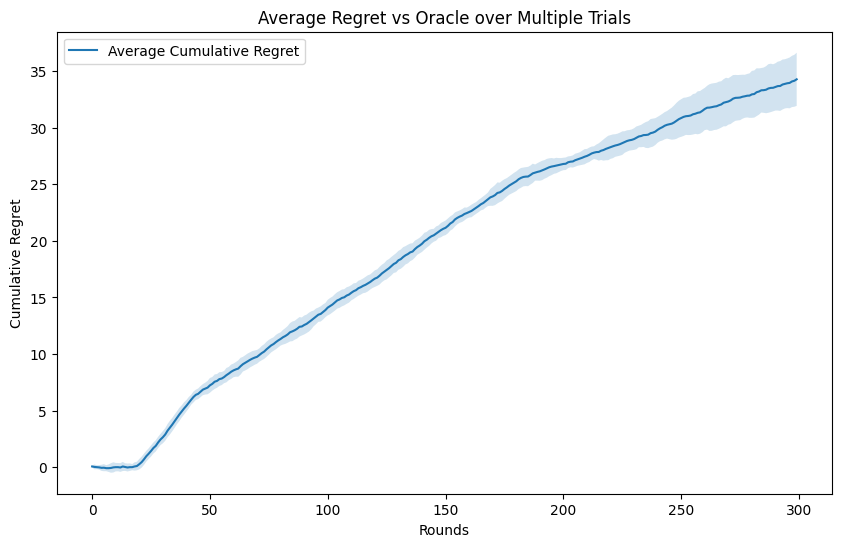

In [5]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices, joint_type='dirichlet', dirichlet_alpha=[2,3,4])
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

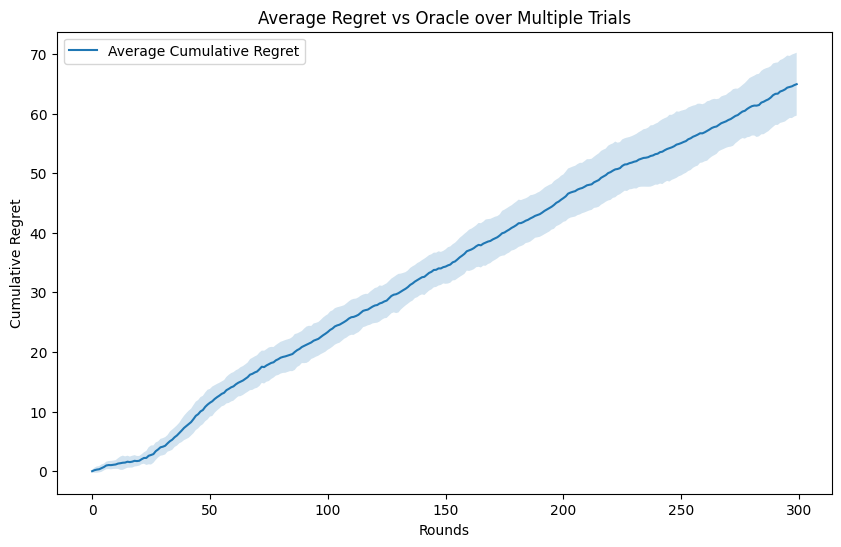

In [6]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices, joint_type='multivariate_uniform')
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

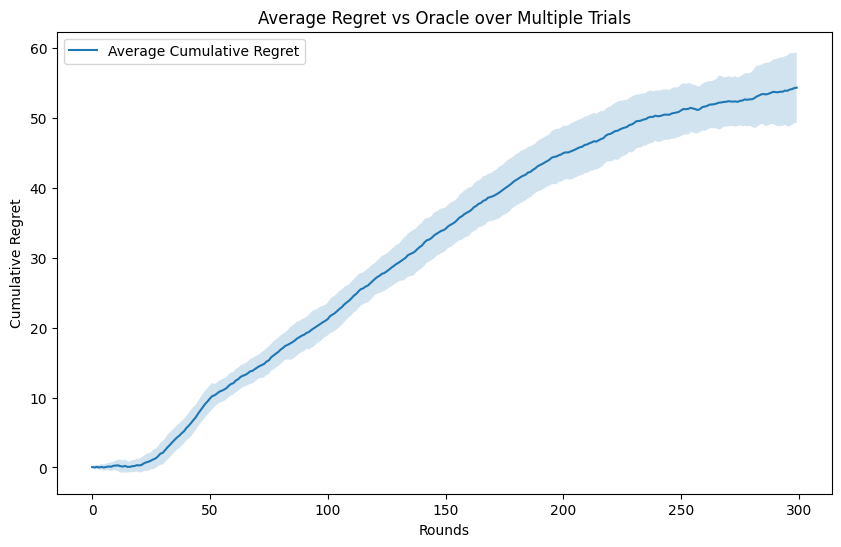

In [7]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices, joint_type='correlated_beta',copula_param=0.7)
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

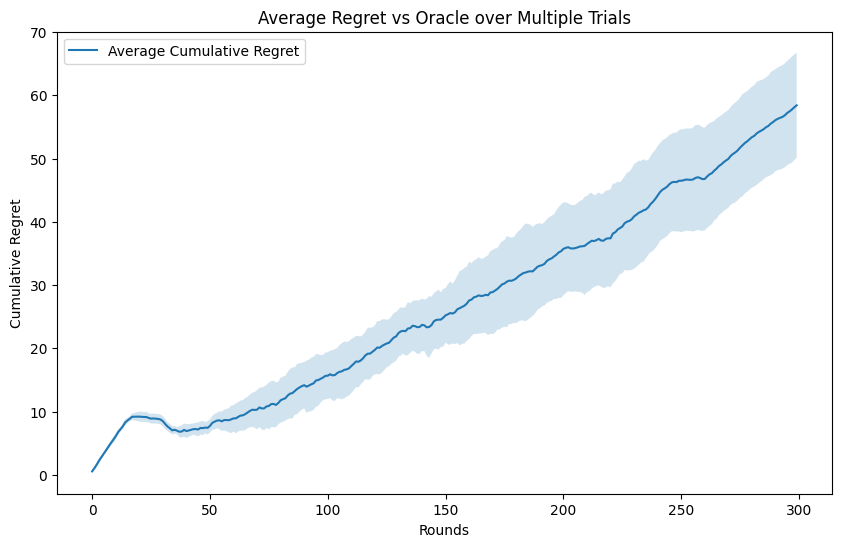

In [9]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices, copula_type='gumbel',
    copula_param=2.0,
    marginal_type='beta',
    a=5, b=2)
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

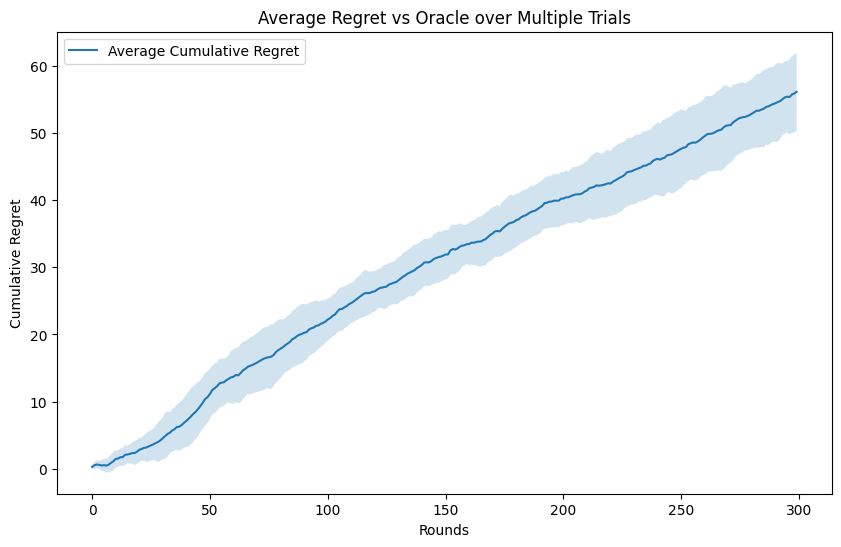

In [10]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices,
    copula_type='clayton',
    copula_param=2.0,
    marginal_type='beta',
    a=2, b=5)
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

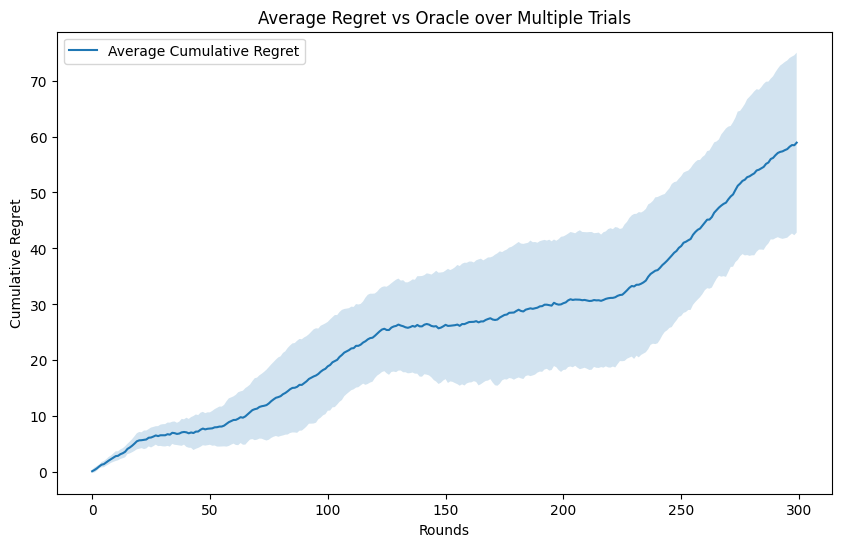

In [11]:
# -----------------------------
# Run Simulation with Multiple Trials
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

products = ['A','B','C']
prices = {'A':[0.2,0.5,0.8], 'B':[0.1,0.4,0.9], 'C':[0.2,0.5,0.9]}
budget = 80
T = 300
n_trials = 10

all_regrets = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(products, prices,
    copula_type='t',
    copula_param=0.7,
    marginal_type='beta',
    a=2, b=2)
    agent = OptimisticBandit(products, prices, budget, T)
    env.remaining_budget = budget

    cumulative_regret = []
    cum_reg = 0

    for t in range(1,T+1):
        if env.remaining_budget <= 0:
            break
        rho_t = env.remaining_budget/(T-t+1)
        action = agent.play(t, rho_t)
        sold, reward = env.round(action)
        outcomes = { (p, action[p]): (reward if sold[i]>0 else 0, sold[i]) for i,p in enumerate(products) }
        agent.update(outcomes, t)

        _, exp_oracle_reward = oracle_action(products, prices, env, rho_t)
        cum_reg += exp_oracle_reward - reward
        cumulative_regret.append(cum_reg)

    all_regrets.append(cumulative_regret)

# Compute average regret over trials
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()